### Import Dependencies

In [31]:
import csv      #for read write csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load CSV Data

In [ ]:
df = pd.read_csv(r'water_data.csv')
array = np.array(df)

#delete redundent column and check data
array = array[:,0:7]
print(array[:,6])

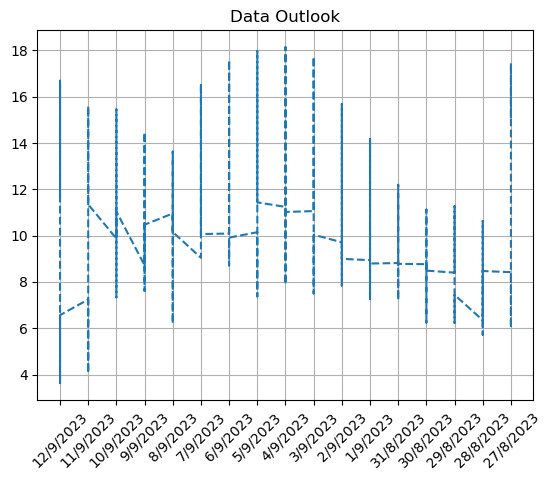

In [88]:
#Plot data and have a look
plt.figure()
plt.title('Data Outlook')
plt.plot(np.transpose(array[:,1]), np.transpose(array[:,5]), linestyle='--')
plt.xticks(rotation=45)
plt.grid()
plt.show()